In [1]:
# Some necessary imports.
import dcgpy
import pygmo as pg
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Fundamental for plotting.
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# We load our data from some available ones shipped with dcgpy.
# In this particular case we use the problem sinecosine from the paper:
# Vladislavleva, Ekaterina J., Guido F. Smits, and Dick Den Hertog.
# "Order of nonlinearity as a complexity measure for models generated by symbolic regression via pareto genetic
# programming." IEEE Transactions on Evolutionary Computation 13.2 (2008): 333-349.
X, Y = dcgpy.generate_sinecosine()

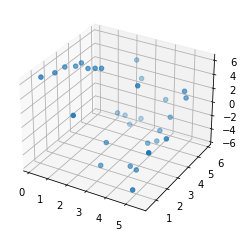

In [3]:
from mpl_toolkits.mplot3d import Axes3D
# And we plot them as to visualize the problem.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], Y[:,0])

In [4]:
# We define our kernel set, that is the mathematical operators we will
# want our final model to possibly contain. What to choose in here is left
# to the competence and knowledge of the user. A list of kernels shipped with dcgpy
# can be found on the online docs. The user can also define its own kernels (see the corresponding tutorial).
ss = dcgpy.kernel_set_double(["sum", "diff", "mul", "sin", "cos"])

In [5]:
# We instantiate the symbolic regression optimization problem
# Note how we specify to consider one ephemeral constant via
# the kwarg n_eph. We also request 100 kernels with a linear
# layout (this allows for the construction of longer expressions) and
# we set the level back to 101 (in an attempt to skew the search towards
# simple expressions)
udp = dcgpy.symbolic_regression(
    points = X, labels = Y, kernels=ss(),
    rows = 1,
    cols = 100,
    n_eph = 1,
    levels_back = 101,
    multi_objective=True)
prob = pg.problem(udp)
print(udp)

	Data dimension (points): 2
	Data dimension (labels): 1
	Data size: 30
	Kernels: [sum, diff, mul, sin, cos]
	Loss: MSE



In [6]:
# We instantiate here the evolutionary strategy we want to use to
# search for models. Note we specify we want the evolutionary operators
# to be applied also to the constants via the kwarg *learn_constants*
uda  = dcgpy.momes4cgp(gen = 250, max_mut = 4)
algo = pg.algorithm(uda)
algo.set_verbosity(10)

In [7]:
# We use a population of 100 individuals
pop = pg.population(prob, 100)

In [8]:
# Here is where we run the actual evolution. Note that the screen output
# will show in the terminal (not on your Jupyter notebook in case
# you are using it). Note you will have to run this a few times before
# solving the problem entirely.
pop = algo.evolve(pop)

In [9]:
# Compute here the non dominated front.
ndf = pg.non_dominated_front_2d(pop.get_f())

In [10]:
# Inspect the front and print the proposed expressions.
print("{: >20} {: >30}".format("Loss:", "Model:"), "\n")
for idx in ndf:
    x = pop.get_x()[idx]
    f = pop.get_f()[idx]
    a = parse_expr(udp.prettier(x))[0]
    print("{: >20} | {: >30}".format(str(f[0]), str(a)), "|")

               Loss:                         Model: 

  0.8735440518437129 | (c1 - sin(c1) + cos(x0))*cos(x0*sin(x1)) + sin(c1) |
   4.586973894620809 | (x1 - sin(c1))*cos(x0*sin(x1)) + cos(c1 - x0) |
  4.6767465166805255 | (x1 - sin(c1))*cos(x0*sin(x1)) + sin(c1) |
    7.95083385475888 | 2*c1*cos(x1)**2 + c1 - x0 + sin(c1 - x0) |
    8.05636094192399 | c1 + x0*cos(x0*sin(x1)) + x1*sin(x1) |
   8.114829188979822 |   c1*cos(x1)**2 - x0 + cos(x0) |
   8.378443072098442 |         2*cos(x0*cos(c1 + x1)) |
    8.38118807770806 |              2*cos(x0*sin(x1)) |
   9.232931980800045 |           c1*cos(x0) + c1 - x0 |
   9.752317527886339 |            c1 - x0 + 2*cos(x0) |
  11.206378829679041 |              c1 - x0 + cos(x0) |
  12.707459712281237 |                  2*cos(x0 - 1) |
  13.422370193371659 |                      c1 - 2*x0 |
   13.48675830156421 |                        c1 - x0 |
  18.679277437831495 |                             c1 |
   18.85767317484314 |                       

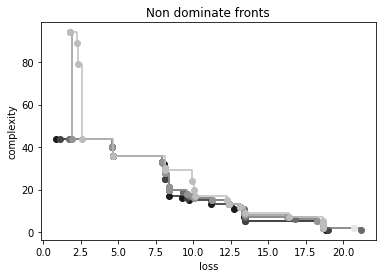

In [11]:
# Lets have a look to the non dominated fronts in the final population.
ax = pg.plot_non_dominated_fronts(pop.get_f())
_ = plt.xlabel("loss")
_ = plt.ylabel("complexity")
_ = plt.title("Non dominate fronts")

In [12]:
# Here we get the log of the latest call to the evolve
log = algo.extract(dcgpy.momes4cgp).get_log()
gen = [it[0] for it in log]
loss = [it[2] for it in log]
compl = [it[4] for it in log]

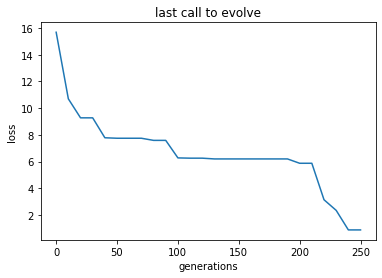

In [13]:
# And here we plot, for example, the generations against the best loss
_ = plt.plot(gen, loss)
_ = plt.title('last call to evolve')
_ = plt.xlabel('generations')
_ = plt.ylabel('loss')